In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
url = '/content/drive/MyDrive/soft/'

In [ ]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [73]:
batch_size = 70
num_iters = 15000
input_dim = 28*28
num_hidden = 260
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

43


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:648
Test dataloader:162


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 =nn.ReLU()

 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5=nn.ReLU()

 
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 =nn.ReLU()

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=250, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=250, out_features=250, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=250, out_features=250, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=250, out_features=250, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=250, out_features=250, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=250, out_features=250, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=250, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [74]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 0.7071045637130737. Accuracy: 75.79748919530768
Epoch:  2
Iteration: 1000. Loss: 0.4494919776916504. Accuracy: 78.67874048158058
Epoch:  3
Iteration: 1500. Loss: 0.3284059464931488. Accuracy: 81.6834739658366
Epoch:  4
Iteration: 2000. Loss: 0.25101014971733093. Accuracy: 80.63387528298004
Iteration: 2500. Loss: 0.9000265598297119. Accuracy: 74.48034575015436
Epoch:  5
Iteration: 3000. Loss: 0.3737266957759857. Accuracy: 80.42807161967482
Epoch:  6
Iteration: 3500. Loss: 0.4511489272117615. Accuracy: 78.02016875900391
Epoch:  7
Iteration: 4000. Loss: 0.23688969016075134. Accuracy: 82.46552788639637
Iteration: 4500. Loss: 0.3572993278503418. Accuracy: 79.87240172875077
Epoch:  8
Iteration: 5000. Loss: 0.9071946740150452. Accuracy: 75.85923029429924
Epoch:  9
Iteration: 5500. Loss: 0.614997148513794. Accuracy: 69.54105783082939
Epoch:  10
Iteration: 6000. Loss: 0.5412932634353638. Accuracy: 81.14838444124305
Epoch:  11
Iteration: 6500. Loss: 0.582317233085

In [75]:
torch.save(model.state_dict(), '/content/drive/MyDrive/soft/model_base.pkl')

[2.0646822452545166, 1.6625207662582397, 1.8120474815368652, 1.6240156888961792, 1.5908585786819458, 2.087599754333496, 1.4512861967086792, 1.8410072326660156, 1.5167564153671265, 1.6547763347625732, 1.9318175315856934, 1.6016809940338135, 1.5917186737060547, 1.6320451498031616, 1.5972360372543335, 1.298028826713562, 1.8795198202133179, 1.7943588495254517, 1.7441775798797607, 1.4773344993591309, 1.3353192806243896, 1.3692021369934082, 1.2158520221710205, 1.360504388809204, 1.5362598896026611, 1.325574278831482, 1.9547544717788696, 1.3481805324554443, 1.0834976434707642, 2.0268640518188477, 1.1822386980056763, 1.170837163925171, 1.2327673435211182, 1.459532618522644, 1.6756646633148193, 1.5001180171966553, 1.2131096124649048, 1.0373425483703613, 1.2974159717559814, 1.284831166267395, 1.5140035152435303, 1.5413496494293213, 0.96664959192276, 1.0102483034133911, 0.6576119661331177, 1.0576159954071045, 1.0871975421905518, 0.8724702596664429, 1.0865894556045532, 0.8107089400291443, 1.208753

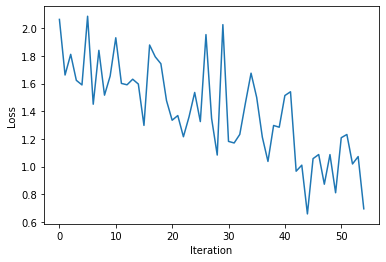

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()